In [ ]:
from liblet import Derivation, Grammar, animate_derivation, ProductionGraph, side_by_side, Tree

# Dalle derivazioni agli alberi di parsing

In [ ]:
def derivation_to_parsetree(d):

    # questa variabile si riferià all'albero di derivazione di d
    # inizialmente contiene l'albero annotato col simbolo di partenza
    tree = Tree({'Symbol': d.G.S, 'nprod': None})

    # all'inizio la forma sentenziale è data da tale albero
    frontier = [tree, ] 

    for nprod, pos in d.steps():

        # i figli sono dati dal lato destro d.G.P[prod].rhs
        children = [Tree({'Symbol': X, 'nprod': None}) for X in d.G.P[nprod].rhs]

        # l'albero è dato dalla posizione in cui è applicata la produzione
        curr = frontier[pos]

        # si aggiornano l'albero e la forma sentenziale
        curr.root['nprod'] = nprod
        curr.children = children
        frontier = frontier[:pos] + children + frontier[pos + 1:]

    return tree

# Le ε-produzioni

In alcuni casi sono comode produzioni della forma $A\to \epsilon$ (chiamate ε-produzioni). Nella costruzione dell'albero dalla derivazione richiedono però un po' di attenzione…

Consideriamo ad esempio il caso del [linguaggio di Dyck](https://en.wikipedia.org/wiki/Dyck_language)

In [ ]:
G_dyck = Grammar.from_string('S -> S S | ( S ) | ε')

In [ ]:
# una derivazione leftmost di '(())'

dyck = 0, 1, 1, 2, 2

deriv = Derivation(G_dyck).leftmost(dyck)
deriv

S -> S S -> ( S ) S -> ( ( S ) ) S -> ( ( ) ) S -> ( ( ) )

In [ ]:
# la parola 
''.join(deriv.sentential_form())

'(())'

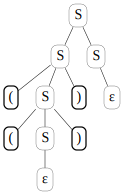

In [ ]:
# l'albero 

ProductionGraph(deriv)

Applicando la funzione `derivation_to_parsetree` si nota però un errore: sembra che da `)` derivi ε!

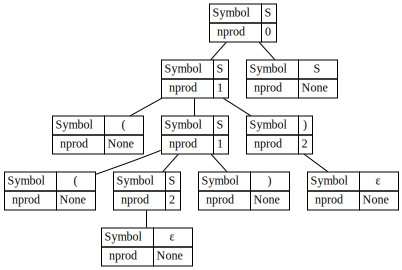

In [ ]:
derivation_to_parsetree(deriv) 

Si lascia come esercizio correggere la funzione `derivation_to_parsetree` in modo che funzioni correttamente anche nel caso di ε-produzioni.

# Ambiguità


## È sempre rilevante? 

Pensiamo a grammatiche della forma `E -> E op E | n` dove `op` sia un operatore binario, definiamo una funzione ricorsiva che, dato un albero di parsing e il valore di `n`, valuti l'espressione aritmetica corrispondente.

In [ ]:
from operator import add, sub, mul

DT = {
  '+': add,
  '-': sub,
  '*': mul
}

def eval_tree(tree, n):
  root, *children = tree
  if root['Symbol'] == 'n': return n
  if root['Symbol'] == 'E' and len(children) == 3:
    left, op, right = children
    return DT[op.root['Symbol']](eval_tree(left, n), eval_tree(right, n))
  else: return eval_tree(children[0], n)

### Il caso "spurio"

In [ ]:
# Costruzione di una derivazione leftomst

def lmd(G, leftmost_steps):
  return Derivation(G).leftmost(leftmost_steps)

In [ ]:
G_as = Grammar.from_string('E -> E + E | n')

# due derivazioni di n + n + n

lmd0, lmd1 = lmd(G_as, [0, 1, 0, 1, 1]), lmd(G_as, [0, 0, 1, 1, 1])

side_by_side(ProductionGraph(lmd0), ProductionGraph(lmd1))

In [ ]:
# 1 + 1 + 1, comunque parsato, vale 3

eval_tree(derivation_to_parsetree(lmd0), 1), eval_tree(derivation_to_parsetree(lmd1), 1)

(3, 3)

### I casi "essenziali"

Iniziamo dall'associatività/commutatività

In [ ]:
G_ae = Grammar.from_string('E -> E - E | n')

# due derivazioni di n - n - n

lmd0, lmd1 = lmd(G_ae, [0, 1, 0, 1, 1]), lmd(G_ae, [0, 0, 1, 1, 1])

side_by_side(ProductionGraph(lmd0), ProductionGraph(lmd1))

In [ ]:
# 1 - (1 - 1) e (1 - 1) - 1 hanno valori diversi!

eval_tree(derivation_to_parsetree(lmd0), 1), eval_tree(derivation_to_parsetree(lmd1), 1)

(1, -1)

Consideriamo la *precedenza* 

In [ ]:
G_perr = Grammar.from_string("""
E -> E + E | E * E | n
""")

# n + n * n

lmd0, lmd1 = lmd(G_perr, [1, 0, 2, 2, 2]), lmd(G_perr, [0, 2, 1, 2, 2])

side_by_side(ProductionGraph(lmd0), ProductionGraph(lmd1))

In [ ]:
# ((2 + 2) * 2) e 2 + (2 * 2) hanno valori diversi!

eval_tree(derivation_to_parsetree(lmd0), 2), eval_tree(derivation_to_parsetree(lmd1), 2)

(8, 6)

Per finire, un esempio non collegato alle *espressioni*, ma al *dangling else*

In [ ]:
G_iferr = Grammar.from_string("""
S -> if C then S | if C then S else S | stm
C -> cond
""")

In [ ]:
# if cond the if cont then stm else stm

lmd0, lmd1 = lmd(G_iferr, [0, 3, 1, 3, 2, 2]), lmd(G_iferr, [1, 3, 0, 3, 2, 2])

side_by_side(ProductionGraph(lmd0), ProductionGraph(lmd1))

## Possibili soluzioni

Un simbolo in più, ricorsione *sinistra* o *destra* e relazione con l'*associatività*. Iniziamo con l'associatibità a sinistra.

In [ ]:
G_la = Grammar.from_string("""
E -> E + E' | E'
E' -> n 
""")
G_la

Grammar(N={E, E'}, T={+, n}, P=(E -> E + E', E -> E', E' -> n), S=E)

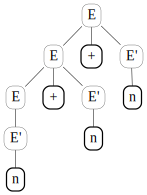

In [ ]:
ProductionGraph(lmd(G_la, [0, 0, 1, 2, 2, 2]))

E quindi consideriamo quella a destra.

In [ ]:
G_ra = Grammar.from_string("""
E -> E' ^ E | E'
E' -> n 
""")
G_ra

Grammar(N={E, E'}, T={^, n}, P=(E -> E' ^ E, E -> E', E' -> n), S=E)

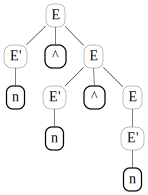

In [ ]:
ProductionGraph(lmd(G_ra, [0, 2, 0, 2, 1, 2]))

Per la *precedenza* occorre aggiungere più di un simbolo…

In [ ]:
G_p = Grammar.from_string("""
E -> E + P | P
P -> P * F | F
F -> n
""")

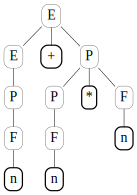

In [ ]:
ProductionGraph(lmd(G_p, [0, 1, 3, 4, 2, 3, 4, 4]))

Il caso del *dangling else*

In [ ]:
G_if = Grammar.from_string("""
S -> M | U
M -> if C then M else M | stm
U -> if C then M else U | if C then S
C -> cond
""")

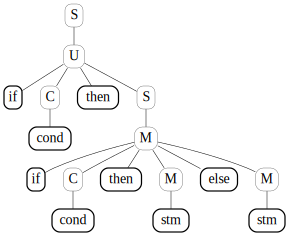

In [ ]:
ProductionGraph(lmd(G_if, [1, 5, 6, 0, 2, 6, 3, 3]))

# Parsing

## Top down

In [ ]:
w = 'aabbcc'

G = Grammar.from_string("""
S -> a S Q | a b c
b Q c -> b b c c  
c Q -> Q c
""", False)

In [ ]:
animate_derivation(Derivation(G).step([
  (0, 0), (1, 1), (3, 3), (2, 2)
]), height = '350px')

interactive(children=(IntSlider(value=0, description='n', max=4), Output(layout=Layout(height='350px'))), _dom…

## Bottom up

Nel caso *bottom up* si può procedere con una grammatica ottenuta rovesciando le produzioni (e aggiungendo una produzione `Inizio`$\to \omega$ dove `Inizio` è il nuovo simbolo di partenza (e volendo una produzione $S\to $`Fine` dove `Fine` è un simbolo usato per indicare la fine della derivazione).

In [ ]:
GR = Grammar.from_string("""
Inizio -> a a b b c c
a S Q -> S
a b c -> S 
b b c c -> b Q c
Q c -> c Q
S -> Fine
""", False)

In [ ]:
animate_derivation(Derivation(GR).step([
  (0, 0), (3, 2), (4, 3), (2, 1), (1, 0), (5, 0)
]), height = '500px')

interactive(children=(IntSlider(value=0, description='n', max=6), Output(layout=Layout(height='500px'))), _dom…